In [1]:
import time
import os
import argparse
import json
import cv2
import sys
sys.path += [os.path.abspath('../keras-yolo3-master')]

from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from tensorflow.keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from panel_disconnect import disconnect




# Define Image Path and output

In [2]:
input_path   = '../images/Mision 23_DJI_0061.jpg' 
#output_path  = 'Result_Complete_Example/'
#makedirs(output_path)

# Load Model (Panel Detector, Soiling, Diode, Cell Damage)

In [3]:
## Config of trained model, change this for use different trained model
config_path_panel  = 'config_full_yolo_panel_infer.json' #Panel
config_path_soiling  = 'config_full_yolo_fault_1_infer.json' #Soiling
config_path_diode  = 'config_full_yolo_fault_4_infer.json'  #Diode
config_path_cellD  = 'config_full_yolo_fault_2_infer.json'  #Cell Damage





## Parameters of detection
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh, nms_thresh_panel = 0.5, 0.45, 0.3

####################################################
#####   Load the model Panel Detector  #############
####################################################
with open(config_path_panel) as config_buffer:
        config_panel = json.load(config_buffer)

os.environ['CUDA_VISIBLE_DEVICES'] = config_panel['train']['gpus']
infer_model_panel = load_model(config_panel['train']['saved_weights_name'])

####################################################
#####   Load the model Soiling  #############
####################################################
with open(config_path_soiling) as config_buffer:
        config_soiling = json.load(config_buffer)

infer_model_soiling = load_model(config_soiling['train']['saved_weights_name'])

####################################################
#####   Load the model Diode  #############
####################################################
with open(config_path_diode) as config_buffer:
        config_diode = json.load(config_buffer)

infer_model_diode = load_model(config_diode['train']['saved_weights_name'])

####################################################
#####   Load the model Cell Damage  #############
####################################################
with open(config_path_cellD) as config_buffer:
        config_cellD = json.load(config_buffer)

infer_model_cellD = load_model(config_cellD['train']['saved_weights_name'])

# Load Image paths

In [11]:
image_paths = []

if os.path.isdir(input_path):
    for inp_file in os.listdir(input_path):
        image_paths += [input_path + inp_file]
else:
    image_paths += [input_path]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

# the main loop
times = []


# Detection of images

images/Mision 23_DJI_0061.jpg
Elapsed time = 5.464144468307495


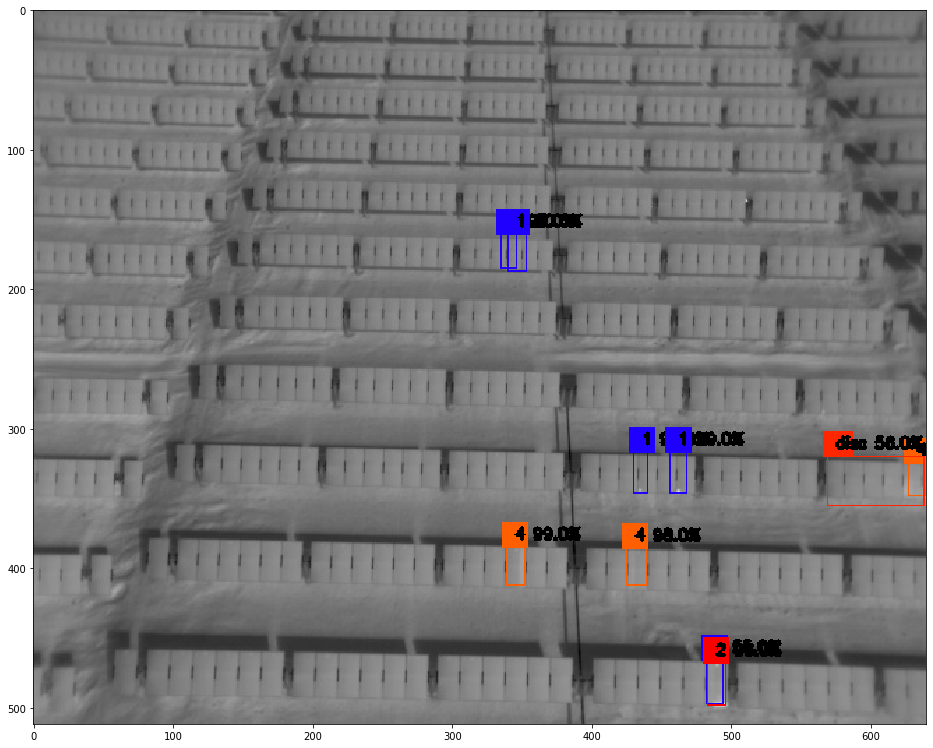

In [13]:
for image_path in image_paths:
    image = cv2.imread(image_path)
    print(image_path)
    start = time.time()
    # predict the bounding boxes
    boxes_soiling = get_yolo_boxes(infer_model_soiling, [image], net_h, net_w, config_soiling['model']['anchors'], obj_thresh, nms_thresh)[0]
    boxes_diode = get_yolo_boxes(infer_model_diode, [image], net_h, net_w, config_diode['model']['anchors'], obj_thresh, nms_thresh)[0]
    boxes_cellD = get_yolo_boxes(infer_model_cellD, [image], net_h, net_w, config_cellD['model']['anchors'], obj_thresh, nms_thresh)[0]
    boxes_panel = get_yolo_boxes(infer_model_panel, [image], net_h, net_w, config_panel['model']['anchors'], obj_thresh, nms_thresh_panel)[0]
    boxes_panel = [box for box in boxes_panel if box.get_score() > obj_thresh]
    boxes_disc = disconnect(image, boxes_panel, z_thresh = 1.8)
    print('Elapsed time = {}'.format(time.time() - start))
    times.append(time.time() - start)
    # Draw boxes
    draw_boxes(image, boxes_soiling, config_soiling['model']['labels'], obj_thresh, number_color = 0)
    draw_boxes(image, boxes_diode, config_diode['model']['labels'], obj_thresh, number_color = 2)
    draw_boxes(image, boxes_cellD, config_cellD['model']['labels'], obj_thresh, number_color = 4)
    draw_boxes(image, boxes_disc, ['disc'], obj_thresh, number_color = 5)
    
    # write the image with bounding boxes to file
    plt.figure(figsize=(16, 16))
    plt.imshow(image)

#file = open(output_path + 'time.txt','w')
#file.write('Tiempo promedio:' + str(np.mean(times)))
#file.close()



# Type Fault
## 1: Soiling Fault
## 2: Affected Cell 
## 4: Diode Fault
## disc: Panel Disconnected